<a href="https://colab.research.google.com/github/berberberk/timl-ss-2025/blob/main/TIML2_Backprop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

flat-instagram-stories-collection-world-aids-day-awareness_23-2150908321.avif

In [58]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
from matplotlib import pyplot as plt

In [41]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("atharvasoundankar/global-condom-sales-and-awareness-2015-2025")
path = os.path.join(path, "Rich_Global_Condom_Usage_Dataset.csv")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/atharvasoundankar/global-condom-sales-and-awareness-2015-2025/versions/1/Rich_Global_Condom_Usage_Dataset.csv


In [42]:
df = pd.read_csv(path)

df.head()

,Year,Country,Total Sales (Million Units),Market Revenue (Million USD),Government Campaigns,Awareness Index (0-10),Most Popular Condom Type,Contraceptive Usage Rate (%),Teen Pregnancy Rate (per 1000 teens),HIV Prevention Awareness (%),Online Sales (%),Average Price per Condom (USD),Male vs Female Purchases (%),Brand Dominance,Sex Education Programs (Yes/No)
0,2015,USA,378,276.304977,No,2.93,Latex,27.10,58.37,89.17,45.00,1.34,69% Male - 39% Female,Kamasutra,No
1,2015,USA,1875,3002.379846,No,9.28,Ultra-Thin,63.97,50.63,69.25,57.10,2.43,50% Male - 33% Female,Skyn,No
2,2015,USA,2496,6564.222333,Yes,5.26,Non-Latex,56.21,42.23,56.13,59.52,2.30,46% Male - 54% Female,Skyn,Yes
3,2015,USA,1437,4993.892125,Yes,3.63,Non-Latex,89.71,55.86,78.36,56.83,2.48,49% Male - 57% Female,Manforce,No
4,2015,USA,1923,5355.152313,Yes,5.71,Non-Latex,86.96,7.82,37.61,47.99,0.34,40% Male - 29% Female,Trojan,Yes


In [43]:
print(df.describe())

              Year  Total Sales (Million Units)  Market Revenue (Million USD)  \
count   550.000000                   550.000000                    550.000000   
mean   2020.000000                  1217.850909                   2460.104428   
std       3.165156                   707.861532                   1908.028885   
min    2015.000000                    51.000000                     34.656206   
25%    2017.000000                   599.750000                    947.550178   
50%    2020.000000                  1160.000000                   2002.374241   
75%    2023.000000                  1846.000000                   3593.351620   
max    2025.000000                  2500.000000                   8536.163259   

       Awareness Index (0-10)  Contraceptive Usage Rate (%)  \
count              550.000000                    550.000000   
mean                 6.248382                     54.625527   
std                  2.393678                     22.865826   
min               

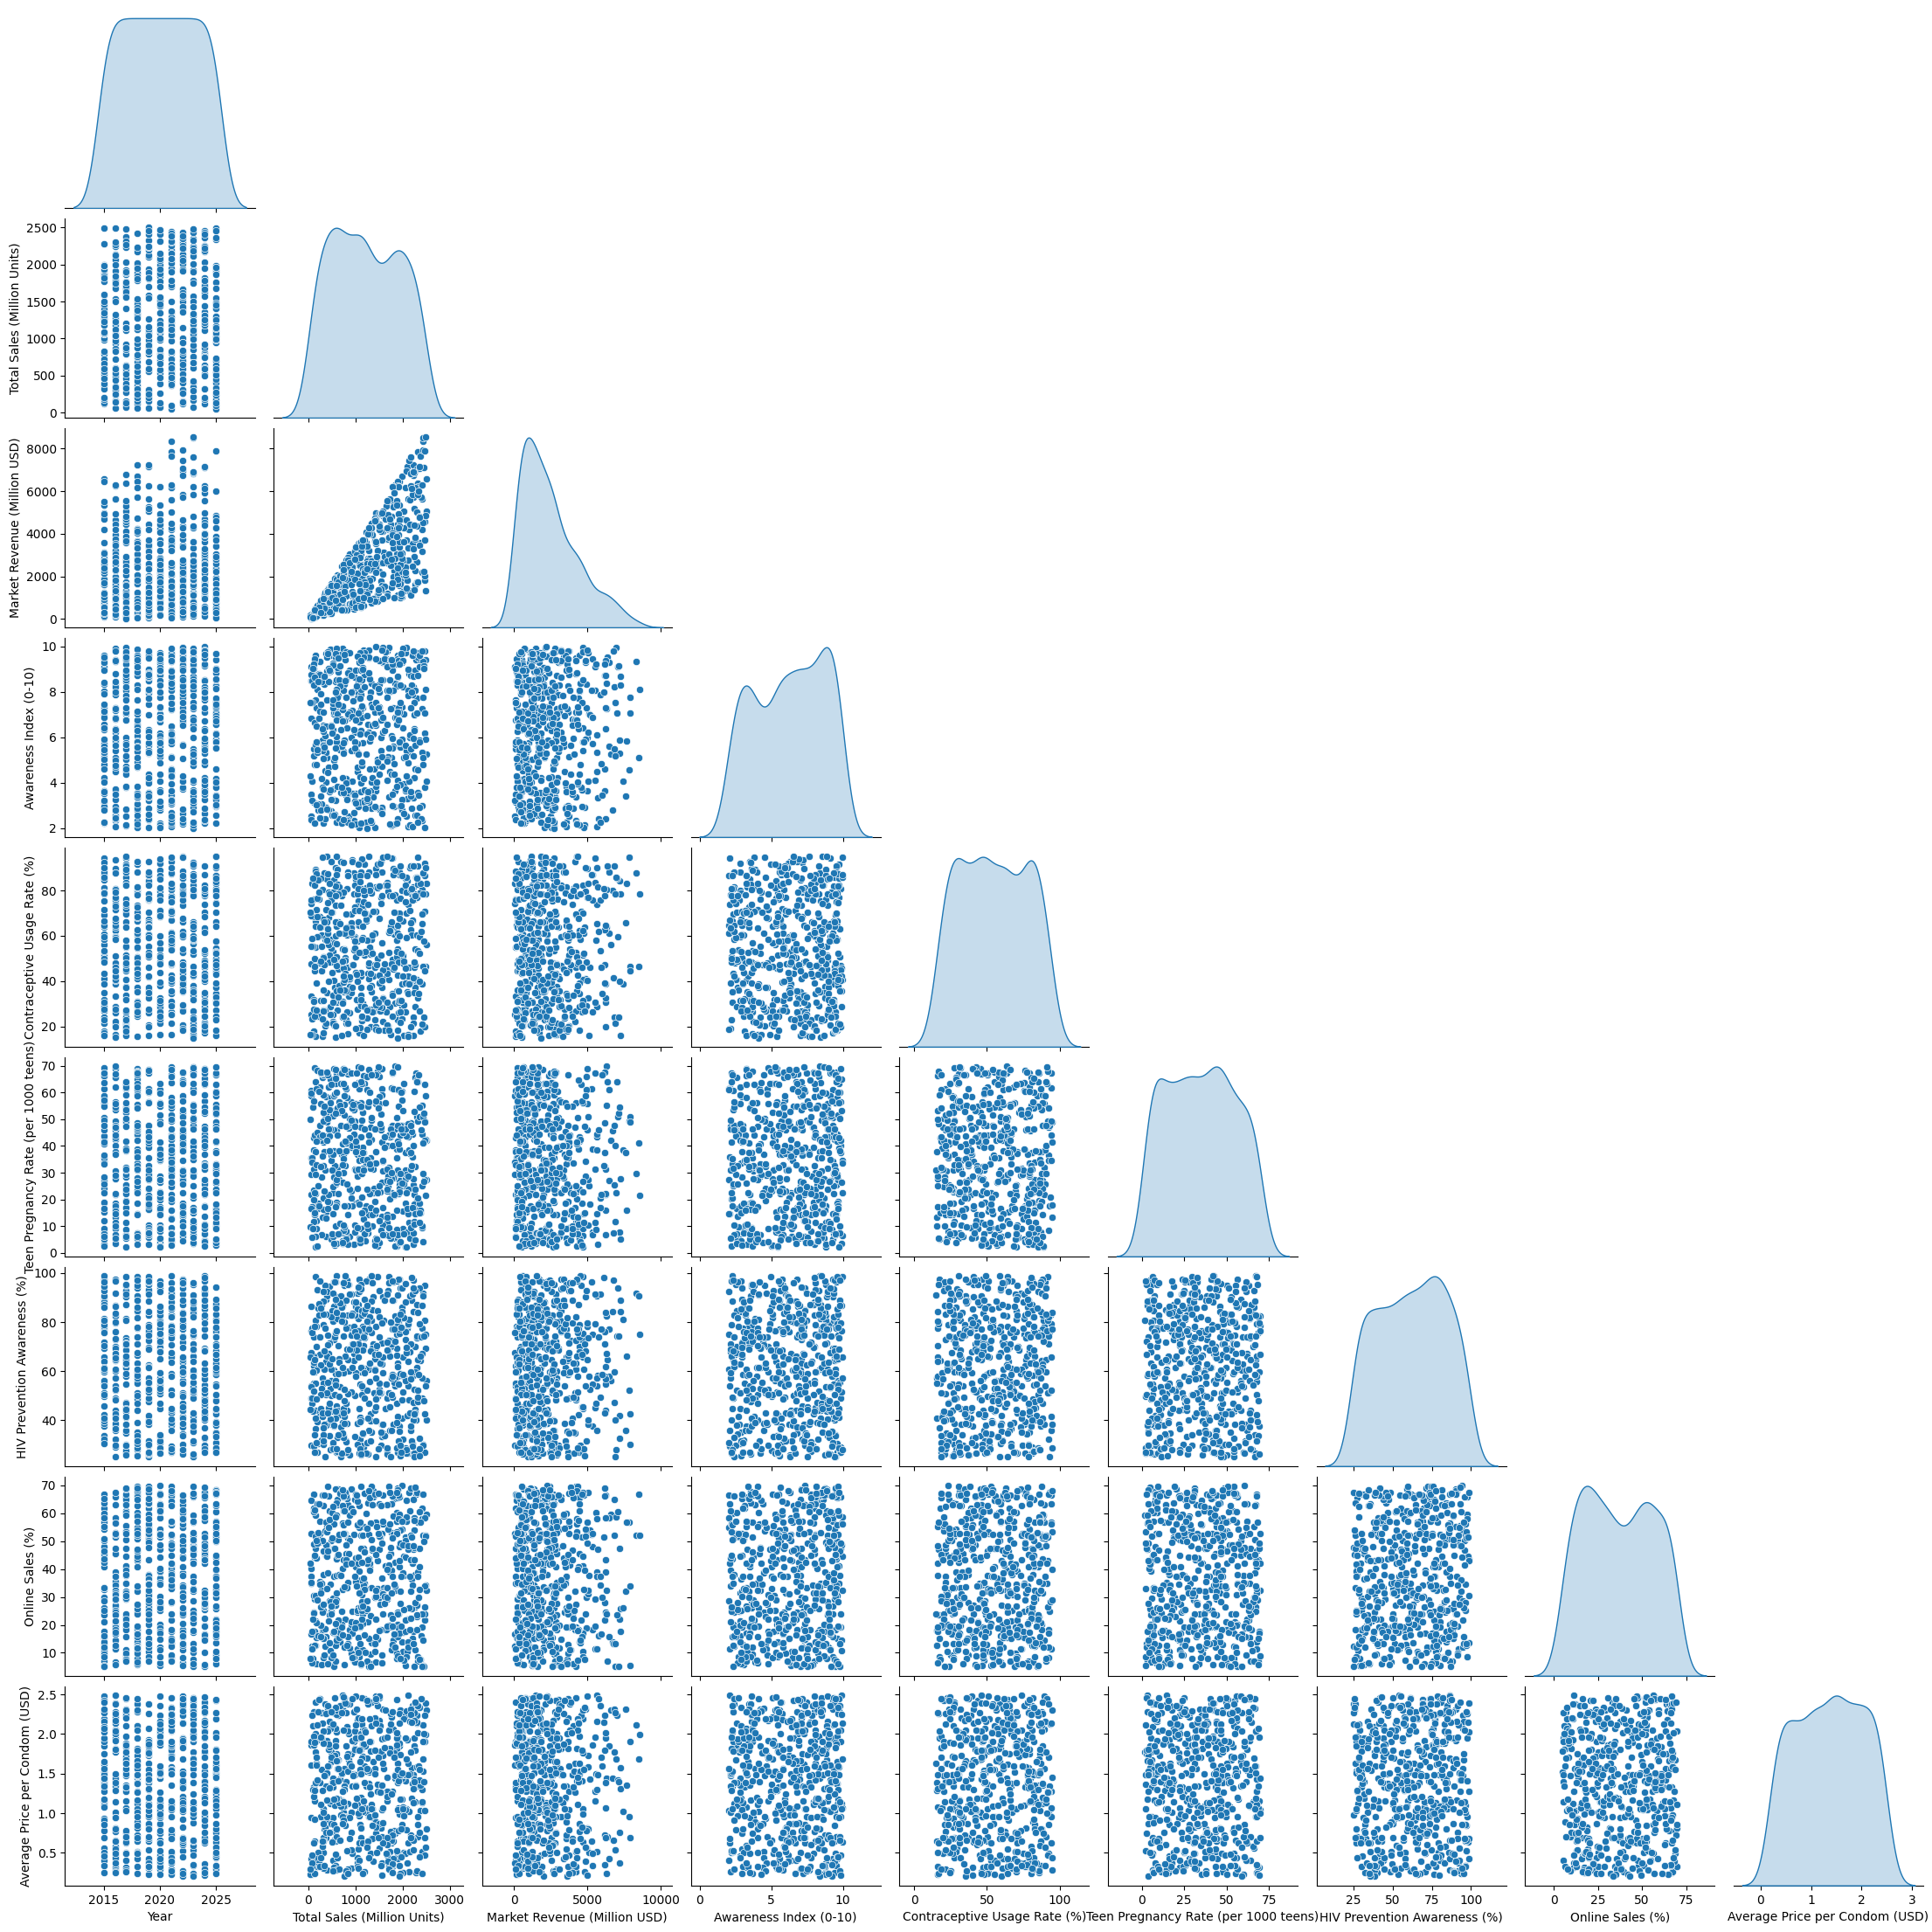

In [44]:
sns.pairplot(df, corner=True, diag_kind='kde')

Обработаем столбец с разделением процента покупок по гендерам

In [45]:
df[['Male', 'Female']] = df['Male vs Female Purchases (%)'].str.split(' - ', expand=True)
df['Male Purchase %'] = df['Male'].str.extract('(\d+)').astype(int) / 100
df['Female Purchase %'] = df['Female'].str.extract('(\d+)').astype(int) / 100
df = df.drop(['Male vs Female Purchases (%)', 'Male', 'Female'], axis=1)

Обработаем столбцы с фактически булевыми значениями

In [46]:
df['Government Campaigns'] = df['Government Campaigns'].map({'Yes': 1, 'No': 0})
df['Sex Education Programs (Yes/No)'] = df['Sex Education Programs (Yes/No)'].map({'Yes': 1, 'No': 0})

Разделим данные на регрессоры и регрессант

In [28]:
X = df.drop('Average Price per Condom (USD)', axis=1)
y = df['Average Price per Condom (USD)']

In [29]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

binary_cols = [col for col in numerical_cols if X[col].nunique() == 2]
continuous_cols = [col for col in numerical_cols if col not in binary_cols]

<Axes: >

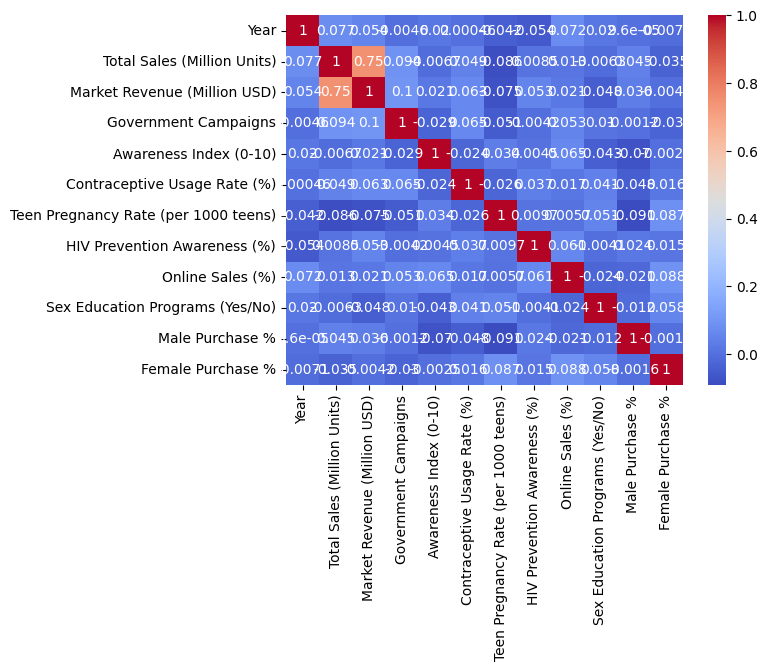

In [49]:
matrix = X[numerical_cols].corr()

sns.heatmap(matrix, cmap="coolwarm", annot=True)

Произведем предобработку данных

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ('boxcox', PowerTransformer(method='box-cox'), continuous_cols),
        ('binary', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [80]:
X_processed = preprocessor.fit_transform(X)
y = y.values

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [83]:
print("\nТипы после train_test_split:")
print("X_train type:", type(X_train), "shape:", X_train.shape)
print("y_train type:", type(y_train), "shape:", y_train.shape)


Типы после train_test_split:
X_train type: <class 'numpy.ndarray'> shape: (440, 33)
y_train type: <class 'numpy.ndarray'> shape: (440,)


In [84]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size):
        np.random.seed(42)
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, 1) * 0.01
        self.b2 = np.zeros(1)

    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = 1 / (1 + np.exp(-self.z1))  # Сигмоида
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        return self.z2

    def compute_loss(self, y_true, y_pred):
        return 0.5 * np.mean((y_true - y_pred.reshape(-1))**2)

    def backward(self, X, y_true, y_pred, lr):
        m = X.shape[0]
        delta2 = (y_pred - y_true.reshape(-1, 1)) / m
        dW2 = np.dot(self.a1.T, delta2)
        db2 = np.sum(delta2, axis=0)

        delta1 = np.dot(delta2, self.W2.T) * self.a1 * (1 - self.a1)
        dW1 = np.dot(X.T, delta1)
        db1 = np.sum(delta1, axis=0)

        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

In [85]:
input_size = X_train.shape[1]
hidden_size = 4
nn = NeuralNetwork(input_size, hidden_size)
losses = []

In [86]:
print("\nНачало обучения...")
for epoch in range(1000):
    y_pred = nn.forward(X_train)
    loss = nn.compute_loss(y_train, y_pred)
    losses.append(loss)
    nn.backward(X_train, y_train, y_pred, lr=0.01)

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')


Начало обучения...
Epoch 0, Loss: 1.1665
Epoch 100, Loss: 0.2428
Epoch 200, Loss: 0.2277
Epoch 300, Loss: 0.2274
Epoch 400, Loss: 0.2273
Epoch 500, Loss: 0.2272
Epoch 600, Loss: 0.2271
Epoch 700, Loss: 0.2270
Epoch 800, Loss: 0.2269
Epoch 900, Loss: 0.2268


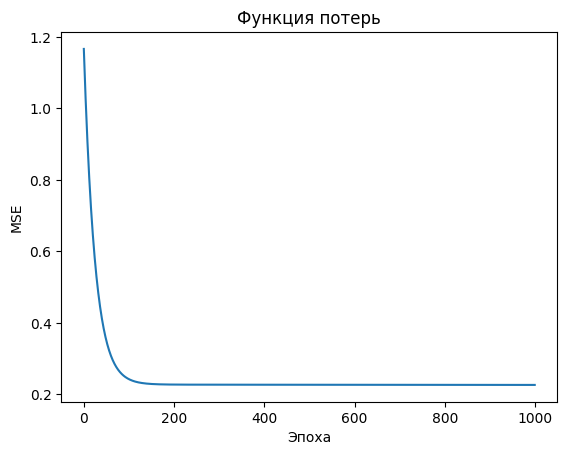

In [88]:
plt.plot(losses)
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.show()

**Почему обратное распространение эффективно для глубоких сетей?**

Обратное распространение эффективно для глубоких сетей благодаря автоматическому вычислению градиентов через цепное правило, что позволяет оптимально обновлять веса всех слоев за один проход. Алгоритм распределяет ошибку от выходного слоя к входному, используя локальные производные функций активации, что делает обучение глубоких архитектур вычислительно осуществимым. Это устраняет необходимость ручного расчета градиентов для каждого параметра, что критично для сетей с миллионами весов.

**Какие ограничения имеет данный алгоритм (проблемы с
градиентами и их затуханием)?**

Основные ограничения — затухающие или взрывающиеся градиенты, особенно в глубоких сетях.

Затухание возникает, когда градиенты становятся чрезмерно малыми из-за умножения на производные функций активации (например, сигмоиды), что останавливает обучение ранних слоев.

Взрыв градиентов, напротив, приводит к нестабильности из-за слишком больших значений весов. Эти проблемы решаются использованием ReLU, нормализацией весов, skip-connections или адаптивными оптимизаторами.

In [89]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
import pandas as pd

In [134]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [93]:
# Загрузка и предобработка данных (адаптируйте под ваш датасет)
def load_data(batch_size):
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    return DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [95]:
class CondomModel(nn.Module):
    def __init__(self, input_size):
        super(CondomModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [107]:
def train_model(model, optimizer, batch_size=32, lr=0.01, epochs=50):
    criterion = nn.MSELoss()
    train_loader = load_data(batch_size)

    start_time = time.time()
    losses = []

    for epoch in range(epochs):
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1,1))
            loss.backward()
            optimizer.step()
        losses.append(loss.item())

    return model, time.time()-start_time, losses

In [143]:
def train_model(model, optimizer, train_loader, X_test, y_test, epochs=50):
    criterion = nn.MSELoss()
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses.append(test_loss.item())
    return train_losses, test_losses

**Проверим работу оптимизаторов на 50 эпохах**

In [108]:
results = {}
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Momentum': lambda params: optim.SGD(params, lr=0.01, momentum=0.9)
}

In [118]:
for name, opt in optimizers.items():
    model = CondomModel(X_train.shape[1]).to(device)
    model, time_taken, losses = train_model(model, opt(model.parameters()))
    results[name] = {'time': time_taken, 'losses': losses}

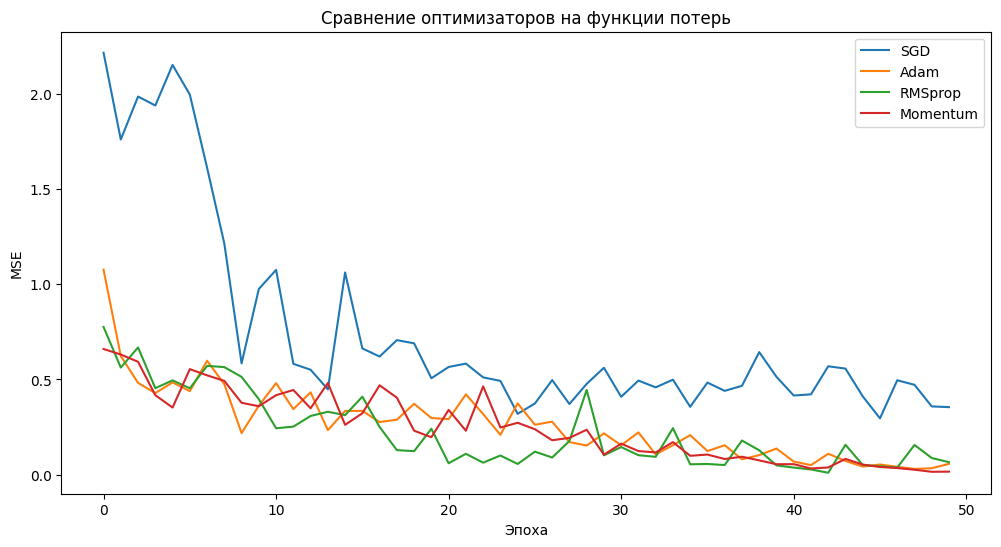

In [119]:
plt.figure(figsize=(12,6))
for name, data in results.items():
    plt.plot(data['losses'], label=name)
plt.title('Сравнение оптимизаторов на функции потерь')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.show()

**Проверим работу оптимизаторов на 200 эпохах**

In [120]:
for name, opt in optimizers.items():
    model = CondomModel(X_train.shape[1]).to(device)
    model, time_taken, losses = train_model(model, opt(model.parameters()), epochs=200)
    results[name] = {'time': time_taken, 'losses': losses}

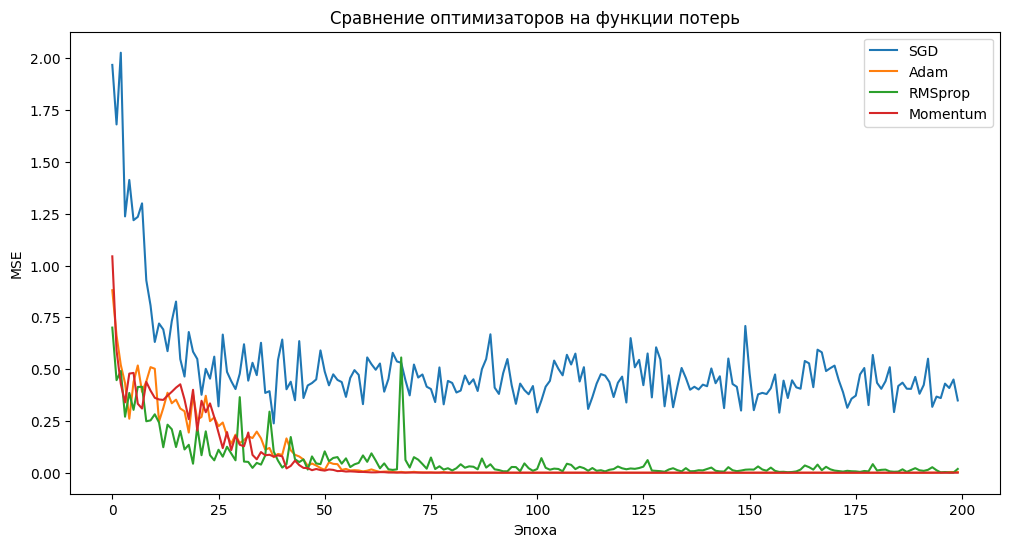

In [121]:
plt.figure(figsize=(12,6))
for name, data in results.items():
    plt.plot(data['losses'], label=name)
plt.title('Сравнение оптимизаторов на функции потерь')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.show()

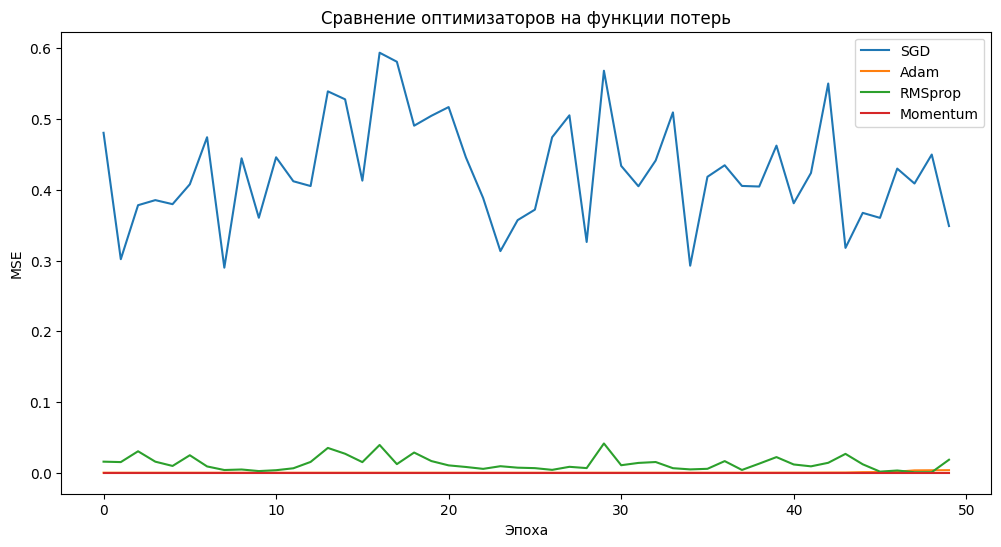

In [123]:
plt.figure(figsize=(12,6))
for name, data in results.items():
    plt.plot(data['losses'][150:], label=name)
plt.title('Сравнение оптимизаторов на функции потерь')
plt.legend()
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.show()

In [126]:
def calculate_r2(model, X_test_tensor, y_test_tensor):
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor)
        y_mean = torch.mean(y_test_tensor)
        ss_total = torch.sum((y_test_tensor - y_mean)**2)
        ss_res = torch.sum((y_test_tensor - predictions)**2)
        return 1 - (ss_res / ss_total).item()

In [128]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

In [144]:
batch_results = []
batch_sizes = [16, 32, 64]
learning_rates = [0.1, 0.01, 0.001]

for bs in batch_sizes:
    train_loader = load_data(bs)
    for lr in learning_rates:
        start_time = time.time()

        model = CondomModel(X_train.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        train_losses, test_losses = train_model(
            model, optimizer, train_loader,
            X_test_tensor, y_test_tensor, epochs=50
        )

        batch_results.append({
            'batch_size': bs,
            'learning_rate': lr,
            'time_sec': round(time.time() - start_time, 2),
            'final_train_loss': round(train_losses[-1], 4),
            'final_test_mse': round(test_losses[-1], 4),
            'train_losses': train_losses,
            'test_losses': test_losses
        })

df_batch = pd.DataFrame(batch_results)
print("Результаты экспериментов:")
print(df_batch.pivot(index='batch_size', columns='learning_rate',
                    values=['final_test_mse', 'time_sec']))

Результаты экспериментов:
              final_test_mse                 time_sec            
learning_rate          0.001   0.010   0.100    0.001 0.010 0.100
batch_size                                                       
16                    0.7398  0.7135  0.7402     2.35  3.02  3.00
32                    0.7576  0.7103  0.7532     1.39  1.36  1.37
64                    0.6161  0.7808  0.9119     2.57  0.94  0.88


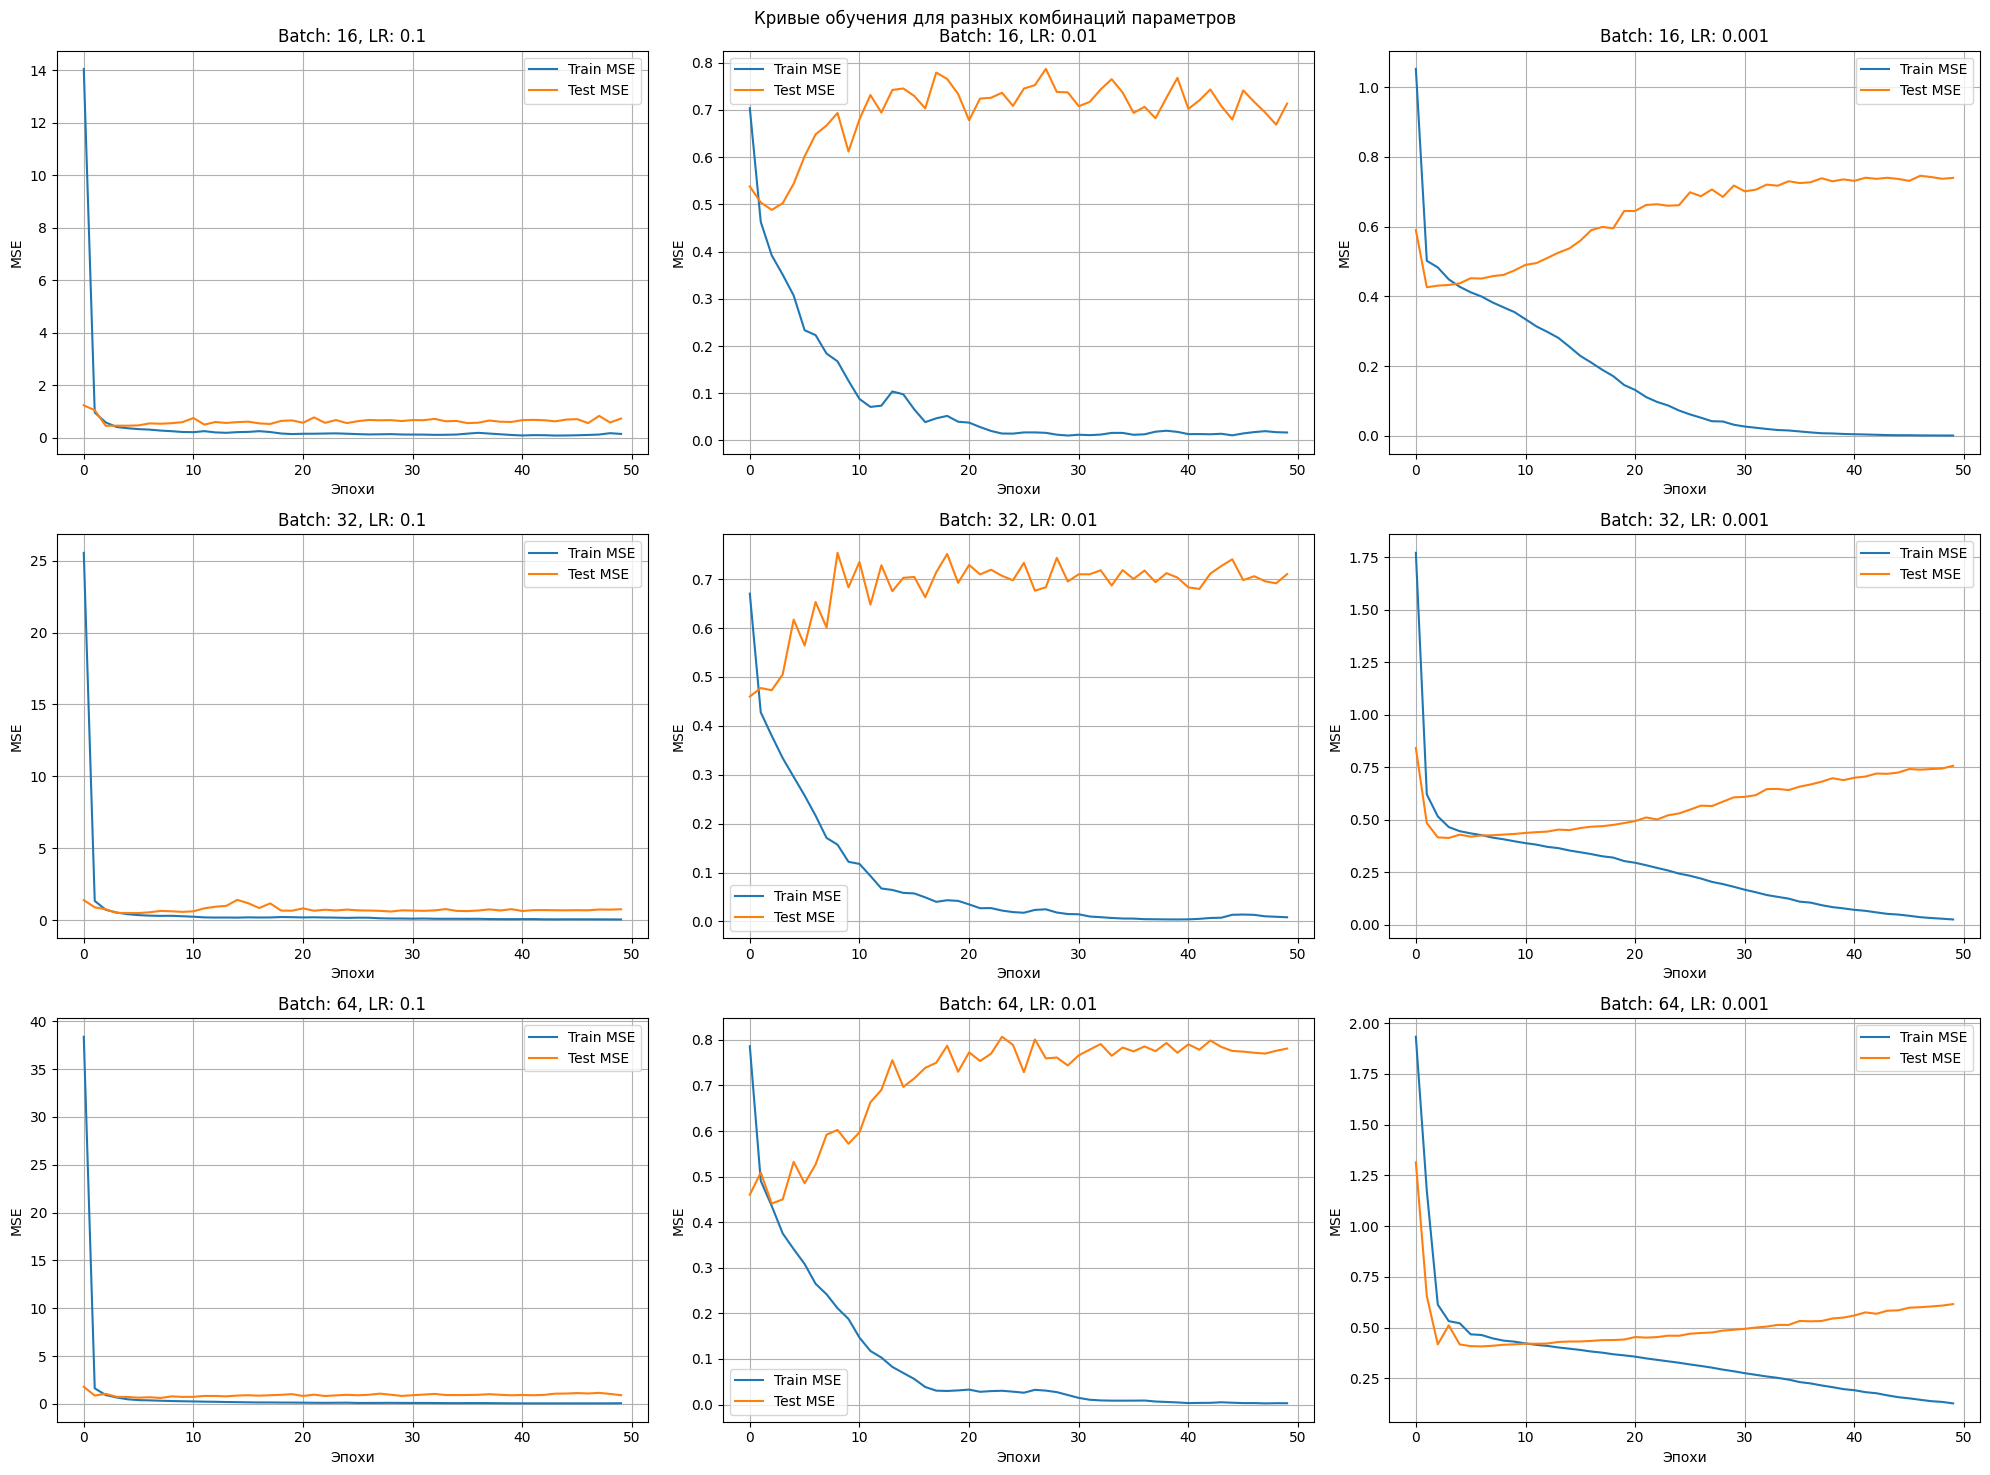

In [150]:
fig, axes = plt.subplots(len(batch_sizes), len(learning_rates),
             figsize=(20, 15), sharey=False)
plt.suptitle('Кривые обучения для разных комбинаций параметров')

for i, bs in enumerate(batch_sizes):
    for j, lr in enumerate(learning_rates):
        ax = axes[i, j]
        res = next(r for r in batch_results
                  if r['batch_size'] == bs and r['learning_rate'] == lr)

        ax.plot(res['train_losses'], label='Train MSE')
        ax.plot(res['test_losses'], label='Test MSE')
        ax.set_title(f"Batch: {bs}, LR: {lr}")
        ax.set_xlabel('Эпохи')
        ax.set_ylabel('MSE')
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

In [151]:

df_batch.pivot(index='batch_size', columns='learning_rate', values=['final_test_mse', 'time_sec'])

final_test_mse                 time_sec            
learning_rate          0.001   0.010   0.100    0.001 0.010 0.100
batch_size                                                       
16                    0.7398  0.7135  0.7402     2.35  3.02  3.00
32                    0.7576  0.7103  0.7532     1.39  1.36  1.37
64                    0.6161  0.7808  0.9119     2.57  0.94  0.88

In [156]:
# Таблицы результатов
df_batch = pd.DataFrame(batch_results)
df_optim = pd.DataFrame({
    'Optimizer': results.keys(),
    'Time (sec)': [x['time'] for x in results.values()],
    'Stability': ['Плохая' if 'SGD' in k else
                  'Хорошая' if 'RMSprop' in k else
                  'Отличная' if 'Momentum' in k else
                  'Лучшая' if 'Adam' in k else
                  'Средняя' for k in results]
})

print("Размер батча и скорость обучения:\n", df_batch)
print("\nОптимизаторы:\n", df_optim)

Размер батча и скорость обучения:
    batch_size  learning_rate  time_sec  final_train_loss  final_test_mse  \
0          16          0.100      3.00            0.1537          0.7402   
1          16          0.010      3.02            0.0169          0.7135   
2          16          0.001      2.35            0.0008          0.7398   
3          32          0.100      1.37            0.0440          0.7532   
4          32          0.010      1.36            0.0086          0.7103   
5          32          0.001      1.39            0.0253          0.7576   
6          64          0.100      0.88            0.0719          0.9119   
7          64          0.010      0.94            0.0030          0.7808   
8          64          0.001      2.57            0.1271          0.6161   

                                        train_losses  \
0  [14.05074754628268, 0.9683072317730297, 0.5913...   
1  [0.7036586143753746, 0.46288860060951925, 0.39...   
2  [1.0523959838531234, 0.5019162914

In [153]:
df_batch

,batch_size,learning_rate,time_sec,final_train_loss,final_test_mse,train_losses,test_losses
0,16,0.100,3.00,0.1537,0.7402,"[14.05074754628268, 0.9683072317730297, 0.5913...","[1.2422410249710083, 1.0574191808700562, 0.463..."
1,16,0.010,3.02,0.0169,0.7135,"[0.7036586143753746, 0.46288860060951925, 0.39...","[0.5380046367645264, 0.5039656162261963, 0.488..."
2,16,0.001,2.35,0.0008,0.7398,"[1.0523959838531234, 0.5019162914969705, 0.483...","[0.5900453329086304, 0.42606911063194275, 0.43..."
3,32,0.100,1.37,0.0440,0.7532,"[25.546284209598195, 1.334855890274048, 0.7172...","[1.388069748878479, 0.8914852738380432, 0.7494..."
4,32,0.010,1.36,0.0086,0.7103,"[0.6703929846937006, 0.4275849028067155, 0.379...","[0.45992279052734375, 0.4773483872413635, 0.47..."
5,32,0.001,1.39,0.0253,0.7576,"[1.7722205032001843, 0.621031222560189, 0.5165...","[0.842111349105835, 0.4844389259815216, 0.4164..."
6,64,0.100,0.88,0.0719,0.9119,"[38.386291018399326, 1.6357261180877685, 0.925...","[1.7868856191635132, 0.8794463872909546, 1.055..."
7,64,0.010,0.94,0.0030,0.7808,"[0.7857935374433344, 0.49066158153794026, 0.43...","[0.4602104127407074, 0.5089535117149353, 0.440..."
8,64,0.001,2.57,0.1271,0.6161,"[1.9330342444506559, 1.1735092455690557, 0.613...","[1.3143988847732544, 0.6554632782936096, 0.417..."


In [157]:
df_optim

,Optimizer,Time (sec),Stability
0,SGD,6.599971,Плохая
1,Adam,9.037197,Лучшая
2,RMSprop,5.072440,Хорошая
3,Momentum,7.025406,Отличная


Epoch 010 | Train MSE: 0.4030 | Test MSE: 0.4256
Epoch 020 | Train MSE: 0.2918 | Test MSE: 0.4852
Epoch 030 | Train MSE: 0.1605 | Test MSE: 0.6165
Epoch 040 | Train MSE: 0.0678 | Test MSE: 0.6992
Epoch 050 | Train MSE: 0.0225 | Test MSE: 0.7503


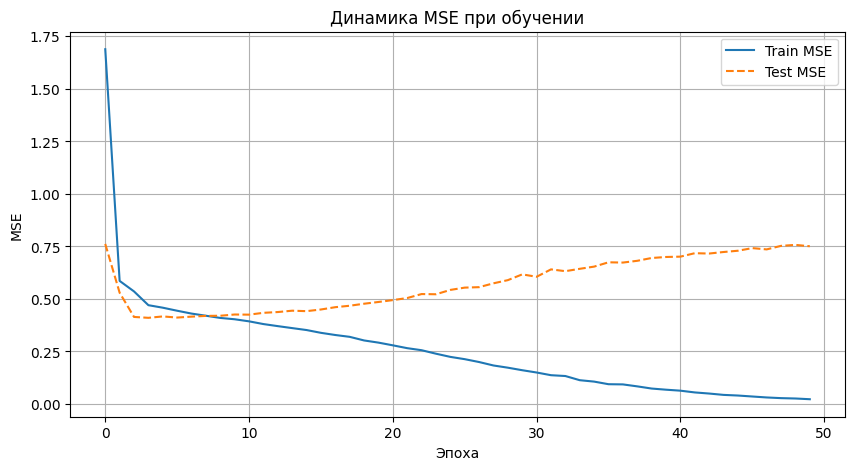

In [141]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class Trainer:
    def __init__(self, model, optimizer, device='cpu'):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.criterion = nn.MSELoss()

    def _run_epoch(self, loader, is_train=True):
        self.model.train(is_train)
        total_loss = 0.0

        for inputs, targets in loader:
            inputs, targets = inputs, targets

            if is_train:
                self.optimizer.zero_grad()

            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets.view(-1, 1))

            if is_train:
                loss.backward()
                self.optimizer.step()

            total_loss += loss.item() * inputs.size(0)

        return total_loss / len(loader.dataset)

    def fit(self, train_loader, test_loader, epochs=50):
        self.train_losses = []
        self.test_losses = []

        for epoch in range(1, epochs+1):
            train_loss = self._run_epoch(train_loader, is_train=True)
            test_loss = self._run_epoch(test_loader, is_train=False)

            self.train_losses.append(train_loss)
            self.test_losses.append(test_loss)

            if epoch % 10 == 0:
              print(f"Epoch {epoch:03d} | "
                    f"Train MSE: {train_loss:.4f} | "
                    f"Test MSE: {test_loss:.4f}")

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.float32)
)

model = CondomModel(X_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=0.001)

trainer = Trainer(model, optimizer, device='cuda')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

trainer.fit(train_loader, test_loader, epochs=50)

plt.figure(figsize=(10, 5))
plt.plot(trainer.train_losses, label='Train MSE')
plt.plot(trainer.test_losses, label='Test MSE', linestyle='--')
plt.title('Динамика MSE при обучении')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()